<a href="https://colab.research.google.com/github/JazmineOrtizMarin/Simulaci-n-2/blob/main/Muestreo_Importancia_Crudo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Muestreo Importancia**

Se implementa el **método de muestreo por importancia** (*Importance Sampling*)  para estimar la integral de una función difícil de evaluar directamente mediante Monte Carlo crudo.


El método de Monte Carlo básico estima una integral del tipo:

$$I = \int_a^b f(x)\,dx$$

aproximándola como un promedio de valores de **f(x)** evaluados en puntos aleatorios **x_i** uniformes:

$$I \approx \frac{b-a}{n} \sum_{i=1}^{n} f(x_i), \qquad x_i \sim U(a,b)$$

Sin embargo, cuando **f(x)** tiene regiones donde contribuye más fuertemente (por ejemplo, picos), este método puede ser ineficiente, ya que gasta muchas muestras en zonas de poca relevancia.

Para mejorar la eficiencia, se introduce una *función de densidad de probabilidad auxiliar* **g(x)**,
de la cual sea fácil generar muestras, y que se parezca en forma a **f(x)**.

El principio es reescribir la integral como:

$$I = \int_a^b f(x)\,dx = \int_a^b \frac{f(x)}{g(x)}\, g(x)\, dx = \mathbb{E}_g\!\left[\frac{f(X)}{g(X)}\right]$$

donde $$X \sim g(x)$$

Entonces, el estimador de Monte Carlo con muestreo por importancia es:

$$\hat{I} = \frac{1}{n} \sum_{i=1}^{n} \frac{f(x_i)}{g(x_i)}, \qquad x_i \sim g(x)$$

Si **g(x)** se elige adecuadamente, este método *reduce la varianza* del estimador y mejora la eficiencia.


In [180]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt
import random as rd

En el código se definen dos funciones:

- **Función objetivo:**

$$f(x) = \cos\!\left(\frac{\pi x}{2}\right)$$

- **Función de importancia:**

$$g(x) = \frac{24}{24-\pi^2} \left( 1 - \frac{\pi^2 x^2}{8} \right)$$

Esta **g(x)** es una función no negativa que integra aproximadamente a **1** en el intervalo **[0,1]**,
por lo que puede servir como una **densidad de probabilidad válida** para generar muestras.

El factor de normalización $$\frac{24}{24-\pi^2}$$ asegura que:

$$\int_0^1 g(x)\,dx \approx 1$$

In [181]:
# Función Objetivo:
def f(x):
  f = np.cos((x*np.pi)/2)
  return f

In [182]:
# Función de Importancia:
def g(x):
  g = (24/(24-np.pi**2)) * (1-((np.pi**2) * (x**2)) / 8)
  return g

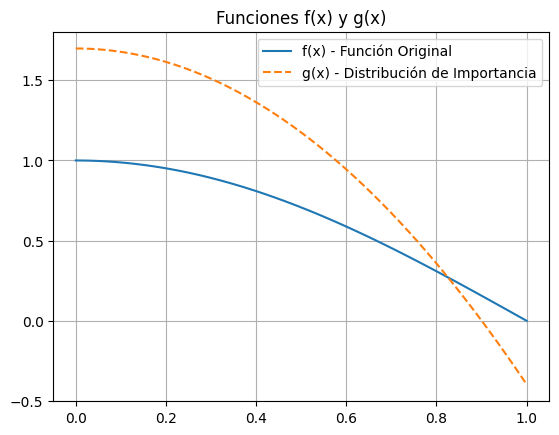

In [183]:
plt.title("Funciones f(x) y g(x)")
xx = np.linspace(0,1,100)
plt.plot(xx,f(xx), label='f(x) - Función Original')
plt.plot(xx,g(xx), label='g(x) - Distribución de Importancia', linestyle='--')
plt.legend()
plt.grid()
plt.show()

Se implementó la función `muestra_g(n)` para generar números aleatorios
conforme a la distribución **g(x)** mediante el método de **Aceptación y Rechazo**.

El procedimiento es:

1. Se genera $$u \sim U(0,1)$$  
2. Se genera $$w \sim U(0,c)$$ donde $$c = \frac{24}{24-\pi^2}$$ es el valor máximo de **g(x)**.  
3. Si $$w \le g(u)$$, se acepta el punto **u**; en caso contrario, se rechaza.  
4. Se repite hasta obtener **n** muestras.

En forma resumida:

$$\text{Aceptar } u \text{ si } w \le g(u).$$

Las muestras aceptadas conforman el conjunto **M**, que sigue la distribución **g(x)**.

In [184]:
def muestra_g(n):
  # Genera 'n' muestras siguiendo la distribución g(x) usando el método de Aceptación-Rechazo.
  c = 24 / (24-np.pi**2) # Constante de normalización
  lista = []
  intentos = 0
  while len(lista) < n:
    u = rd.random() # Candidato de una uniforme
    w = rd.uniform(0,c)
    if w <= g(u):
      lista.append(u)
    intentos += 1
  return lista


In [185]:
M = muestra_g(1000)

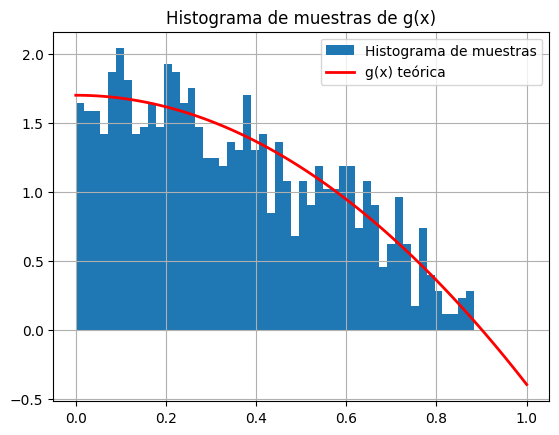

In [186]:
plt.hist(M, bins=50, density=True, label='Histograma de muestras')
plt.plot(xx, g(xx), label='g(x) teórica', color='red', linewidth=2)
plt.title("Histograma de muestras de g(x)")
plt.legend()
plt.grid()
plt.show()

In [187]:
def muestreo_importancia(N):
  # Estima la integral usando Muestreo por Importancia.
  G=[] # Generamos N muestras que siguen la distribución g(x)
  muestras_de_g = muestra_g(N)
  for i in muestras_de_g:
    # Calculamos f(x)/g(x) para cada muestra
    G.append(f(i)/g(i))
  return np.mean(G), np.var(G)

In [188]:
def muestreo_crudo(N):
  # Estima la integral usando el método Monte Carlo Crudo.
  G=[] # Generamos N muestras de una distribución uniforme U(0,1)
  for i in range (N):
    u=rd.random()
    # Calculamos f(u) para cada muestra
    G.append(f(u))
  return np.mean(G), np.var(G)

In [189]:
N_muestras = 10000

In [190]:
media_imp, var_imp = muestreo_importancia(N_muestras)
valor_real = 2/np.pi

In [191]:
print(f"Valor real de la integral: {valor_real:.10f}")

Valor real de la integral: 0.6366197724


In [192]:
print("1. Estimación por Muestreo por Importancia:")
print("---------------------------------------------")
print(f"Media estimada: {media_imp:.10f}")
print(f"Varianza:       {var_imp:.10f}")
print("---------------------------------------------")

1. Estimación por Muestreo por Importancia:
---------------------------------------------
Media estimada: 0.6163147139
Varianza:       0.0175862307
---------------------------------------------


In [193]:
media_crudo, var_crudo = muestreo_crudo(N_muestras)
print("2. Estimación por Muestreo Crudo (Tradicional):")
print("---------------------------------------------")
print(f"Media estimada: {media_crudo:.10f}")
print(f"Varianza:       {var_crudo:.10f}")
print("---------------------------------------------")

2. Estimación por Muestreo Crudo (Tradicional):
---------------------------------------------
Media estimada: 0.6430343535
Varianza:       0.0922030787
---------------------------------------------


In [194]:
if var_imp < var_crudo:
    reduccion = (1 - var_imp / var_crudo) * 100
    print(f"El Muestreo por Importancia redujo la varianza en un {reduccion:.2f}%.")
else:
    print("La varianza no se redujo, la función g(x) no fue una buena elección.")

El Muestreo por Importancia redujo la varianza en un 80.93%.
